# Cross Section Interface

PyNE provides a top-level interface for computing (and caching) multigroup neutron cross sections.
These cross sections will be computed from a variety of available data sources (stored in `nuc_data.h5`).
This interface remains the same across all data sources, allowing the user to easily swap out which 
cross section library they wish to use.

The following cross section formats are included with PyNE.

* The ENDF file format (experimental), 
* The ACE file format, 
* EAF 175-group cross sections,
* CINDER 63-group cross sections,
* A two-point fast/thermal interpolation (using 'simple_xs' data from KAERI),
* Physical models, and
* Null data.

This functionality may be be found in the `xs` sub-package.  This package is 
separated out into the following modules:

    models
    data_source
    cache
    channels

## Data Sources

Data sources are classes that provide the common interface for grabbing cross section data from a data source.  Unless otherwise specified, this is lazily evaluated.  The data source object itself then acts as an in-memory cache, making further look ups of the raw data very quick! 

To get a sense of how this works, let's pull in some data that we know about.  

### EAF Data Source

In [1]:
from pyne.xs.data_source import EAFDataSource, SimpleDataSource, NullDataSource

In [2]:
eds = EAFDataSource()
# reaction returns a dictionary containing source group structure, energy values, 
# cross-section data, and interpolation data.
gamma = eds.reaction('U235', 'gamma')
gamma

array([  3.40601000e-04,   4.13527000e-04,   4.52339000e-04,
         5.35260000e-04,   7.79656000e-04,   9.12824000e-04,
         1.05027000e-03,   1.20057000e-03,   1.33202000e-03,
         1.46200000e-03,   1.60595000e-03,   1.67206000e-03,
         1.76457000e-03,   1.90211000e-03,   2.03703000e-03,
         2.12614000e-03,   2.15500000e-03,   2.15923000e-03,
         2.17015000e-03,   2.19708000e-03,   2.24992000e-03,
         2.34009000e-03,   2.47761000e-03,   2.65621000e-03,
         2.80624000e-03,   2.93429000e-03,   3.18937000e-03,
         3.54963000e-03,   3.99022000e-03,   4.53866000e-03,
         5.21324000e-03,   6.05776000e-03,   7.06523000e-03,
         9.26177000e-03,   1.27481000e-02,   1.75162000e-02,
         2.23344000e-02,   2.54474000e-02,   2.88533000e-02,
         3.21686000e-02,   3.59024000e-02,   4.03127000e-02,
         4.31805000e-02,   4.57085000e-02,   4.57084000e-02,
         4.57112000e-02,   4.87787000e-02,   5.18315000e-02,
         5.62859000e-02,

The data source also provides a method to re-discretize this data to another group structure.

In [3]:
import numpy as np
dst_e_g = np.logspace(1, -7, 11)

# dst_group_struct is the group structure of the destination cross sections.
eds.dst_group_struct = dst_e_g

# discreatizes the reaction channel from the source group structure to that of the
# destination, weighted by the group fluxes.
gamma_c = eds.discretize('U235', 'gamma')
print(gamma_c)
print(dst_e_g)

[  2.52625773e-02   1.50668227e-01   3.94173552e-01   8.29069757e-01
   2.08402584e+00   5.56199103e+00   1.73480167e+01   3.37415300e+01
   1.01908466e+01   2.15494273e+01]
[  1.00000000e+01   1.58489319e+00   2.51188643e-01   3.98107171e-02
   6.30957344e-03   1.00000000e-03   1.58489319e-04   2.51188643e-05
   3.98107171e-06   6.30957344e-07   1.00000000e-07]


Now let's plot it!

In [6]:
from pyne.bins import stair_step
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='serif', size=14)


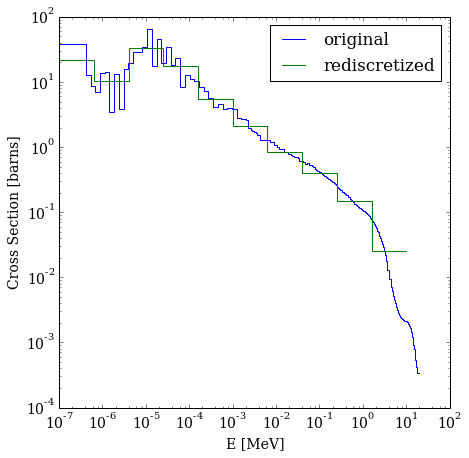

In [13]:
fig = plt.figure(figsize=(7,7))
plt.loglog(*stair_step(eds.src_group_struct, gamma), figure=fig) # original
plt.loglog(*stair_step(eds.dst_group_struct, gamma_c), figure=fig) # new group structure
plt.xlabel('E [MeV]')
plt.ylabel('Cross Section [barns]')
plt.legend(('original', 'rediscretized'))

### Simple Data Source

This interface is independent of where the data came from. As it should be!

In [8]:
sds = SimpleDataSource(dst_group_struct=dst_e_g)
print(sds.exists)
rx = sds.reaction('U233', 'absorption') # cross section data
rxc = sds.discretize('U233', 'absorption') # discretization of data

True


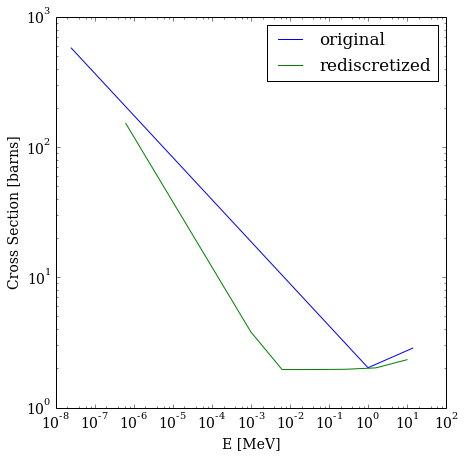

In [12]:
fig = plt.figure(figsize=(7,7))
plt.loglog(sds.src_group_struct[:-1], rx, figure=fig)
plt.loglog(sds.dst_group_struct[:-1], rxc, figure=fig)
plt.xlabel('E [MeV]')
plt.ylabel('Cross Section [barns]')
plt.legend(('original', 'rediscretized'))

Since data sources are caches, subsequent requests for 
the same data are very fast! 

In [10]:
%time sds.reaction('U238', 'fiss')
print
%time sds.reaction('U238', 'fission')
print
%time sds.reaction('U238', 'fiss')
print

CPU times: user 16.7 ms, sys: 1.32 ms, total: 18.1 ms
Wall time: 48.4 ms

CPU times: user 46 µs, sys: 7 µs, total: 53 µs
Wall time: 73 µs

CPU times: user 36 µs, sys: 7 µs, total: 43 µs
Wall time: 61 µs



## Cross Section Caching

Now suppose you want to perform the same discretization and wish to pull cross sections from many sources (with some precedence) based on whether the data is available or not.  Enter `XSCache`.  This is a class to do exactly that.  

This class acts like a dictionary whose keys are `(nuclide, rx)` or `(nuclide, rx, temp)` tuples for the nuclide, reaction id, and temperature that you wish to know.  

In [2]:
from pyne.xs.cache import XSCache

In [16]:
xscache = XSCache(group_struct=dst_e_g,
                  data_sources=[EAFDataSource, SimpleDataSource, NullDataSource])


In [17]:
xscache['U235', 'abs']

array([   1.94057774,    1.71230641,    2.02444418,    3.24912017,
          7.42318537,   20.15919429,   51.8621376 ,   77.11455565,
         46.99610069,  155.69532222])

In [18]:
xscache['H42', 'gamma']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## Reading ACE Files

To load data from an ACE file, one needs to simply initialize an instance of the `Library` class specifying the path to the `Library` file:

    from pyne import ace
    libFile = ace.Library('endf70a')
    libFile.read()
    

## Reading ENDF Files
Similarly, ENDF file reading and cross-section discretization is supported.

In [3]:
import requests
from pyne.xs.data_source import ENDFDataSource
from pyne import nucname
from os.path import isfile

# Download the data file if it isn't there
if not isfile("Ni59.txt"):
    r = requests.get("http://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/Ni/59")
    with open("Ni59.txt", "wb") as outfile:
        outfile.write(r.content)

In [20]:
endfds = ENDFDataSource("Ni59.txt")

# get the nonelastic reaction data for Ni-59
nonelastic_rx = endfds.reaction("Ni59", "nonelastic")

# set the group structure and re-discretize
nonelastic_rx['dst_group_struct'] = np.logspace(7, -5, 33)
nonelastic_c = endfds.discretize("Ni59", "nonelastic")


Now let's plot it!!


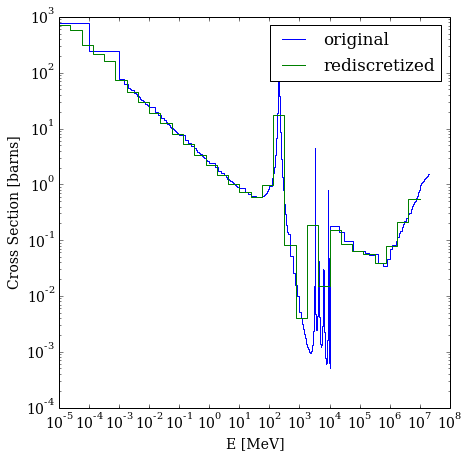

In [22]:
fig = plt.figure(figsize=(7,7))

# e_int is the array of energy values over which to integrate
E_g = nonelastic_rx['e_int']
# xs is the array of cross-sections corresponding to e_int
nonelastic = nonelastic_rx['xs']

# with base group structure
plt.loglog(*stair_step(E_g, nonelastic[:-1]), figure=fig) 
# discretized with new group structure
plt.loglog(*stair_step(nonelastic_rx['dst_group_struct'], nonelastic_c), figure=fig) 
plt.xlabel('E [MeV]')
plt.ylabel('Cross Section [barns]')
plt.legend(('original', 'rediscretized'))

## Cross Section Channels

PyNE also provides an easy interface to very quickly grab multigroup cross sections from the cross section cache and collapse them to the appropriate group structure. This is done in the `pyne.xs.channels` module.  This contains functions such as `sigma_f()` for computing the fission cross section.

The functions in the channels module are extended from what you would normally be able to see from the cache.  For example, you may compute cross sections for materials, fission energy spectra, metastable ratios, etc.

In [4]:
from pyne.xs import channels
from pyne.material import Material, from_atom_frac

In [24]:
fuel = from_atom_frac({'U235': 0.045, 'U238': 0.955, 'O16': 2.0}, mass=1.0, density=10.7)

# the cross section is mapped to fuel with group structure dist_e_g
# the default temp is 300K; this uses a group flux.
channels.sigma_f(fuel, group_struct=dst_e_g)

array([ 0.21836068,  0.11496041,  0.09857257,  0.09597528,  0.10104627,
        0.13585377,  0.22343296,  0.44344517,  0.99609454,  2.38428759])